## Single-step Horizon 1-hour enriched dataset


## Loading all the libraries

In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import optuna
import json
import seaborn as sns

## Preprocessing And Feature Engineering DATASET For XGBoost

In [4]:
#loading pickle file
df = pd.read_pickle('Hourly_Elec_Additional_Data.pkl')


#Ensuring that datetime_hour is a datetime index when we load in the data
df['datetime_hour'] = pd.to_datetime(df['datetime_hour'])
df = df.set_index('datetime_hour')

#Converting the two categorical columns to use in XGBoost
categorical = ['insee_region', 'weather_code']
for col in categorical:
    df[col] = df[col].astype('category')


#Now we sort by region and datetime so we can add the lags
df = df.sort_values(['insee_region', 'datetime_hour'])


#Here we will create the lag features
lags = [1,2,3,4,5,6,24,48,168]
for lag in lags:
    df[f"lag_{lag}h"] = (df.groupby('insee_region')['conso_elec_mw'].shift(lag).transform(lambda x: x.fillna(method = 'bfill', limit = lag)))

#Creating rolling windows  for the rolling features
rolling_windows = [3,6,12,24,48]

#creating the rolling window mean and std features 
for window in rolling_windows:
    df[f"roll_mean{window}h"] = df.groupby('insee_region')['conso_elec_mw'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f"roll_std{window}h"] = df.groupby('insee_region')['conso_elec_mw'].transform(lambda x: x.rolling(window, min_periods=1).std())
    df[f"roll_std{window}h"] = df[f"roll_std{window}h"].fillna(df[f"roll_std{window}h"].mean())


#We will set the target variable and use shift -1, because only 1 hour ahead
df['target_1h'] = df.groupby('insee_region')['conso_elec_mw'].shift(-1)

#Then we will dropp all the rows that are NaN with the target variables.
df = df.dropna(subset=['target_1h'])

## Setting up data

In [4]:
#We make the masks so we can use this to split the data on
mask_train = df['year'].isin([2015,2016,2017])
mask_val = df['year'] == 2018
mask_test = df['year'] == 2019


#Here we set the target feature and the features we use to train the model
X = df.drop(columns=['target_1h'])
y = df['target_1h']


#here we splitt the data up official
X_train, y_train = X[mask_train], y[mask_train]
X_val, y_val = X[mask_val], y[mask_val]
X_test, y_test = X[mask_test], y[mask_test]

## SETTING UP MODEL AND HYPERPARAMETERTUNING

In [6]:
#Here we first define optuna with the parameter ranges to use for hyperparametertuning
def optuna_tuning(tuning):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'n_estimators': tuning.suggest_int('n_estimators', 100, 1000),
        'max_depth': tuning.suggest_int('max_depth', 3,12),
        'learning_rate': tuning.suggest_float('learning_rate', 0.001, 0.3, log = True),
        'subsample': tuning.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': tuning.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': tuning.suggest_float('gamma', 0, 5),
        'reg_alpha': tuning.suggest_float('reg_alpha', 0.00000001, 1.0, log = True),
        'reg_lambda': tuning.suggest_float('reg_lambda', 0.00000001, 1.0, log = True),
        'random_state': 42,
        'enable_categorical': True,
    }
    
    #here we define the model that we will be using
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    y_val_pred  = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    print(f'tune {tuning.number}: MAE = {mae_val:.4f}')
    return mae_val
    
#Here we run the optuna study
tune = optuna.create_study(direction = 'minimize')
tune.optimize(optuna_tuning, n_trials = 25, show_progress_bar = True)
best_parameters = tune.best_params

print('Best parameters:', tune.best_params)
print('Best MAE:', tune.best_value)

## Save the best hyperparameter tuning

In [9]:
with open('best_xgb_params_1H_Additional_Data_forecasting.json', 'w') as f:
    json.dump(tune.best_params, f)

## Opening the parameters (optional)

In [5]:
with open('best_xgb_params_1H_Additional_Data_forecasting.json', 'r') as f:
    loaded_params = json.load(f)
    best_parameters = loaded_params

## Retrain the model with the best hyperparamters

In [8]:
#We select the XGBregressor because we are doing regression and not classification
tuned_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42,
    enable_categorical = True,
    **best_parameters
)

#Fitting on the full training set before predicting with the right hyperparapeter values
tuned_model.fit(X_train, y_train, verbose = False)

## Feature Importance

### Creating subsample for Feature Importance

In [18]:
# setting the parapemeters for the subset data
#here we set to use seven days of hourly data
week_hours = 24 * 7  
months_in_year = X_test['month'].unique() 
X_test_sub = pd.DataFrame()
y_test_sub = pd.DataFrame()

# dataset contains 12 regions, so we need to loop over all regions
for reg in X_test['insee_region'].unique():
    reg_mask = X_test['insee_region'] == reg
    reg_data = X_test.loc[reg_mask]
    reg_target = y_test.loc[reg_mask]

    # we will loop over all months because we take a week of each month
    for month in months_in_year:
        month_mask = reg_data['month'] == month
        month_idx = reg_data[month_mask].index)
        if len(month_idx) >= week_hours:
            selected_idx = month_idx[:week_hours]
        else:
            selected_idx = month_idx

        X_test_sub = pd.concat([X_test_sub, reg_data.loc[selected_idx]])
        y_test_sub = pd.concat([y_test_sub, reg_target.loc[selected_idx]])

# to prevent errors, we need to reset the index
X_test_sub = X_test_sub.reset_index(drop=True)
y_test_sub = y_test_sub.reset_index(drop=True)

print("X_test_sub shape:", X_test_sub.shape)
print("y_test_sub shape:", y_test_sub.shape)

### XGBoost Native Feature Importance (GAIN)

Top Features by Permutation Importance (%):
conso_elec_mw: 73.53%
roll_mean: 6.49%
lags: 5.98%
hour: 5.27%
insee_region: 4.51%
conso_gaz_mw: 1.16%
roll_std: 0.60%
day_of_week: 0.36%
solaire: 0.31%
spot_price_elec_mw: 0.25%
soil_temperature_0_to_7cm: 0.21%
shortwave_radiation: 0.20%
temperature_2m: 0.16%
diffuse_radiation: 0.13%
gdp_in_volume_in_millions: 0.09%


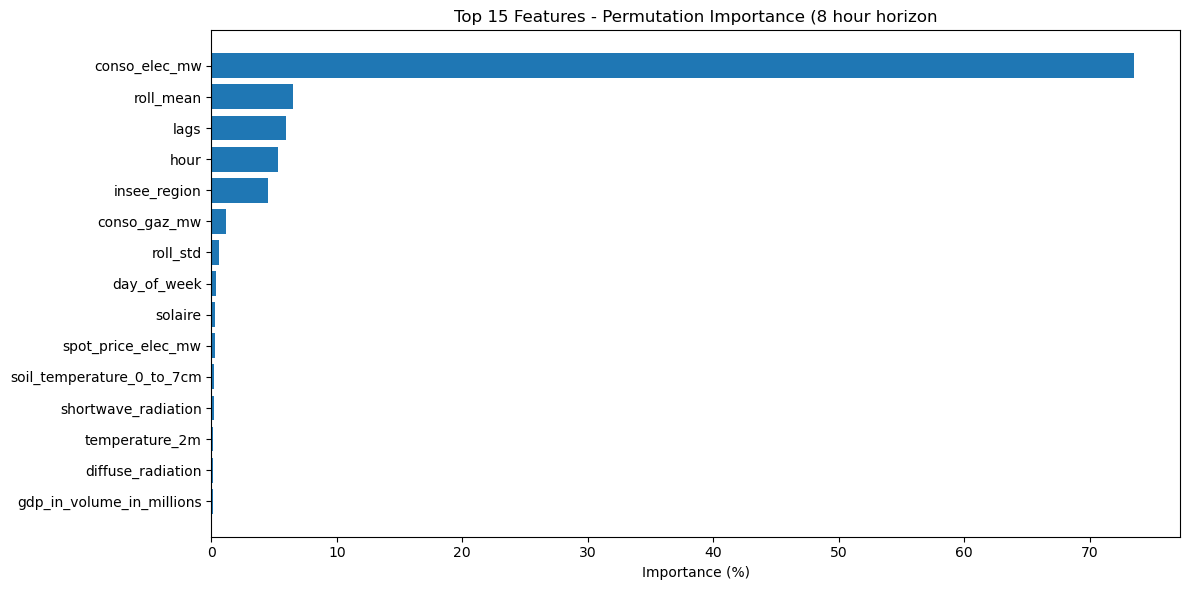

In [18]:
# Get feature importance valyes from XGBoost native model using the gain metric
fi_xgb = tuned_model.get_booster().get_score(importance_type='gain')

# Converting the importance into a DataFRame
fi_xgb_df = pd.DataFrame({
    'feature': list(fi_xgb.keys()),
    'gain': list(fi_xgb.values())
})

# Creating the features based on the one-hot encoded features, to get a better overview
one_hot_groups = {
    'region': [c for c in X_train.columns if 'insee_region_' in c],
    'weather': [c for c in X_train.columns if 'weather_code_' in c],
    'school_zone': [c for c in X_train.columns if 'school_zone_' in c],
    'vacation_name': [c for c in X_train.columns if 'vacation_name_' in c],
    'holiday_name': [c for c in X_train.columns if 'holiday_name_' in c],
    'season': [c for c in X_train.columns if 'season_' in c],
    'lags': [c for c in X_train.columns if 'lag_' in c],
    'roll_mean': [c for c in X_train.columns if 'roll_mean' in c],
    'roll_std': [c for c in X_train.columns if 'roll_std' in c],
}

# aggregating the grouped importance values
group_importances = {}
used_features = set(sum(one_hot_groups.values(), []))

for group_name, cols in one_hot_groups.items():
    subset = fi_xgb_df.loc[fi_xgb_df['feature'].isin(cols), 'gain']
    if subset.empty:
        continue

    # Averaging the importance of the one-hot encoded groups
    if group_name in ['region', 'weather', 'school_zone', 'vacation_name', 'holiday_name', 'season']:
        group_importances[group_name] = subset.mean()
    # Instead of averaging the importance, we sum up for the lag and rol features.
    else:
        group_importances[group_name] = subset.sum()

# after grouping the one-hot encoded features we not add the normal features
for f in fi_xgb_df['feature']:
    if f not in used_features:
        group_importances[f] = fi_xgb_df.loc[
            fi_xgb_df['feature'] == f, 'gain'
        ].values[0]

# creating a table with the importance to see the perccentage easier
fi_xgb_grouped = pd.DataFrame(list(group_importances.items()), columns=['feature', 'gain'])
fi_xgb_grouped['gain_pct'] = 100 * fi_xgb_grouped['gain'] / fi_xgb_grouped['gain'].sum()
fi_xgb_grouped = fi_xgb_grouped.sort_values(by='gain_pct', ascending=False).head(15)
print("Top 15 Grouped XGBoost Native Feature Importances (by Gain):")
print(fi_xgb_grouped.to_string(index=False))

# Creating the plot
plt.figure(figsize=(12, 6))
plt.barh(fi_xgb_grouped['feature'], fi_xgb_grouped['gain_pct'])
plt.xlabel('Feature Importance (% Gain)')
plt.title('Top 15 Grouped Feature Importances: XGBoost(Gain) with exogenous variables')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_grouped_XGB_Gain_1H_With_Exogenous.png', dpi=300, bbox_inches='tight')
plt.show()


### Permutation feature Importance


Top 15 Grouped XGBoost Native Feature Importances (by Gain):

                  feature         gain  gain_pct
                roll_mean 1.547763e+09 61.722671
            conso_elec_mw 8.024013e+08 31.998662
                     lags 1.112878e+08  4.438003
                     hour 8.617413e+06  0.343651
                 roll_std 3.431004e+06  0.136824
              school_zone 2.730074e+06  0.108872
             conso_gaz_mw 2.718315e+06  0.108403
               is_weekend 2.543358e+06  0.101426
gdp_in_volume_in_millions 2.041943e+06  0.081430
              day_of_week 1.603034e+06  0.063927
          total_employees 1.215709e+06  0.048481
 global_tilted_irradiance 1.174881e+06  0.046853
soil_temperature_0_to_7cm 1.144330e+06  0.045634
        diffuse_radiation 1.141620e+06  0.045526
      shortwave_radiation 1.130668e+06  0.045089


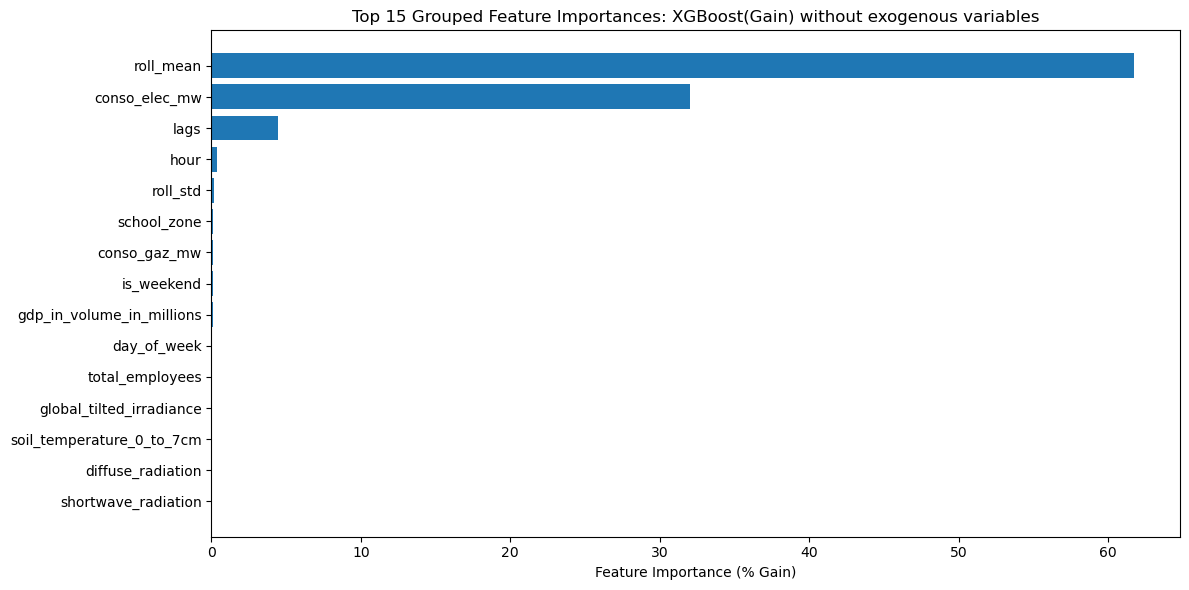

In [19]:
#Setting the parapeters of the permutation importance
n_repeats = 1 #Shuffling only once
top_n = 15  # selecting only the top 15 features
rng = np.random.default_rng(42)

# getting the baseline MAE on the test subset
baseline_pred = tuned_model.predict(X_test_sub)
baseline_score = mean_absolute_error(y_test_sub, baseline_pred)

# Computing the permutation importance 
importances = np.zeros(X_test_sub.shape[1])
X_test_permute = X_test_sub.copy()

for i, col in enumerate(X_test_sub.columns):
    scores = []
    original_col = X_test_permute[col].copy()
    for _ in range(n_repeats):
        X_test_permute[col] = rng.permutation(original_col)
        y_pred_perm = tuned_model.predict(X_test_permute)
        scores.append(mean_absolute_error(y_test_sub, y_pred_perm))
    X_test_permute[col] = original_col
    importances[i] = np.mean(scores) - baseline_score

# Converting the raw values into the percentages
importances_pct = 100 * importances / np.sum(importances)

# Creating the features based on the one-hot encoded features, to get a better overview
one_hot_groups = {
    'region': [c for c in X_test_sub.columns if 'insee_region_' in c],
    'weather': [c for c in X_test_sub.columns if 'weather_code_' in c],
    'school_zone': [c for c in X_test_sub.columns if 'school_zone_' in c],
    'vacation_name': [c for c in X_test_sub.columns if 'vacation_name_' in c],
    'holiday_name': [c for c in X_test_sub.columns if 'holiday_name_' in c],
    'season': [c for c in X_test_sub.columns if 'season_' in c],
    'lags': [c for c in X_test_sub.columns if 'lag_' in c],
    'roll_mean': [c for c in X_test_sub.columns if 'roll_mean' in c],
    'roll_std': [c for c in X_test_sub.columns if 'roll_std' in c],
}

#Preparing arros for the grouped importances 
importances_clean = importances_pct.copy()
feature_names_clean = X_test_sub.columns.to_list()
used_features = set(sum(one_hot_groups.values(), []))

#aggregating the grouped features into their groups
for group_name, cols in one_hot_groups.items():
    mask = [i for i, f in enumerate(feature_names_clean) if f in cols]
    if mask:
        if group_name in ['region','weather','school_zone','vacation_name','holiday_name','season']:
            group_val = importances_clean[mask].mean()
        else:
            group_val = importances_clean[mask].sum()
        importances_clean = np.delete(importances_clean, mask)
        feature_names_clean = [f for i, f in enumerate(feature_names_clean) if i not in mask]
        importances_clean = np.append(importances_clean, group_val)
        feature_names_clean.append(group_name)


# Selecting the top features by importance
top_idx = np.argsort(importances_clean)[-top_n:][::-1]

print("Top Features by Permutation Importance (%):")
for i in top_idx:
    print(f"{feature_names_clean[i]}: {importances_clean[i]:.2f}%")

# Creating the plot
plt.figure(figsize=(12,6))
plt.barh([feature_names_clean[i] for i in top_idx], [importances_clean[i] for i in top_idx])
plt.xlabel("Importance (%)")
plt.title(f"Top {top_n} Features - Permutation Importance (8 hour horizon")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('permutation_feature_importance_8h_With_Exogenous.png', dpi=300, bbox_inches='tight')
plt.show()

## Testing the model and Evaluating general

In [7]:
#Now we will be doing the model  actual predictions on the testset
y_test_pred = tuned_model.predict(X_test)

#Evaluation metrics calculation on the test set
rmse_test = mean_squared_error(y_test, y_test_pred)**0.5
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test))*100

print("The results for the test set")
print(f"RMSE:{rmse_test:.2f}")
print(f"MAE:{mae_test:.2f}")
print(f"MAPE:{mape_test:.2f}")

print('Actual vs Predicited values (first 5 rows):')
print(np.vstack([y_test.values[:5], y_test_pred[:5]]).T)



The results for the test set
RMSE:152.69
MAE:88.58
MAPE:1.10
Actual vs Predicited values (first 5 rows):
[[17381.    16803.2  ]
 [16178.    16115.56 ]
 [15623.    15570.918]
 [14834.    15012.019]
 [14524.    14765.367]]


## Evaluation regional specific

In [15]:
def evaluate_regions(X_test, y_test, y_pred, region_col = 'insee_region'):
    #Creating a dataframe so we can link regions with the true and predicted values
    df  = pd.DataFrame({
        'region': X_test[region_col].values,
        'y_true': y_test.values,
        'y_pred': y_pred })

    #Computing the regional RMSE, MAE and MAPE for all regions
    def region_metrics(group):
        rmse = mean_squared_error(group['y_true'], group['y_pred']) **0.5
        mae = mean_absolute_error(group['y_true'], group['y_pred'])
        mape = np.mean(np.abs((group['y_true'] - group['y_pred']) / group['y_true'])) * 100
        return pd.Series({'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

    return df.groupby('region').apply(region_metrics).reset_index()

#actual evaltion of the model performance across regions
regional_eval = round(evaluate_regions(X_test, y_test, y_test_pred),2)
print("Test Evaluation regional performance")
print(regional_eval)


## Code for creating the error plots

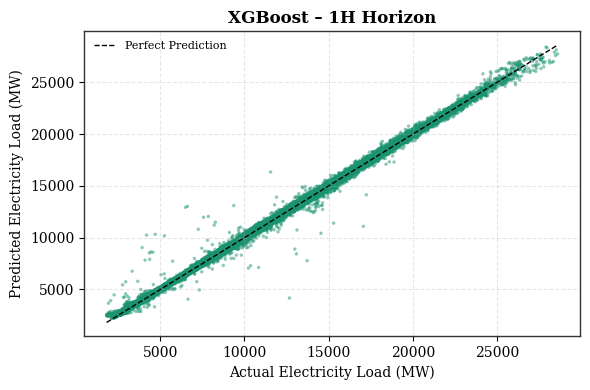

In [23]:
# setting the forecast horizon label for the plot
horizon_name = '1H'


# flatten true and predicted values into array 
y_true_flat = y_test.values.flatten()     
y_pred_flat = y_test_pred.flatten() if isinstance(y_test_pred, np.ndarray) else y_test_pred.values.flatten()

#creating the dataframe for plotting
df = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})

#Setting a professional style
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1

# setting the same color as for the other plots using XGBoost
color_xgb = '#1A936F'

#creating the figure
fig, ax = plt.subplots(figsize=(6, 4))

# creating the scatter plot points
ax.scatter(df['y_true'], df['y_pred'],
           alpha=0.5, s=6, color=color_xgb,
           edgecolor='none', linewidths=0, rasterized=True)

# creating the perfect diagonal line for predictions
min_val = min(df['y_true'].min(), df['y_pred'].min())
max_val = max(df['y_true'].max(), df['y_pred'].max())
ax.plot([min_val, max_val], [min_val, max_val],
        'k--', linewidth=1, label='Perfect Prediction')

# adding labels and titles
ax.set_title(f"XGBoost – {horizon_name} Horizon", fontsize=12, fontweight='bold')
ax.set_xlabel("Actual Electricity Load (MW)", fontsize=10)
ax.set_ylabel("Predicted Electricity Load (MW)", fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(frameon=False, fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig("XGBoost_1H_Enriched_Data_Prediction.png", dpi=600, bbox_inches='tight')
plt.show()


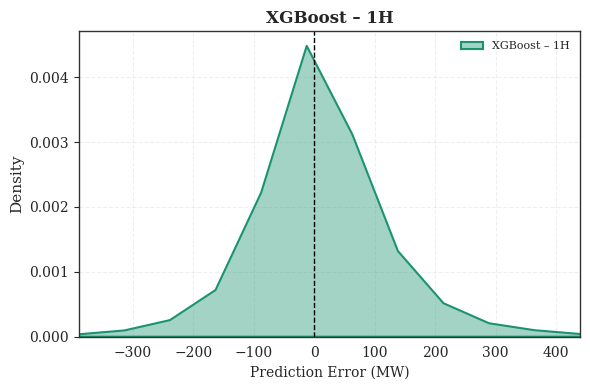

In [15]:
# setting the forecast horizon label for the plot
horizon_name = '1H' 

# flatten true and predicted values into array 
y_true_flat = y_test.values.flatten()
y_pred_flat = y_test_pred.flatten() if isinstance(y_test_pred, np.ndarray) else y_test_pred.values.flatten()


#creating the dataframe for plotting
df = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})
df['error'] = df['y_pred'] - df['y_true']



#Setting a professional style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1

# setting the same color as for the other plots using XGBoost
color_xgb = '#1A936F'

#creating the figure
fig, ax = plt.subplots(figsize=(6, 4))


#drawing the KDE curve 
sns.kdeplot(
    df['error'],
    fill=True, alpha=0.4, color=color_xgb,
    linewidth=1.5, ax=ax, label=f'XGBoost – {horizon_name}'
)

# adding a reference line at the zero error for better visibility
ax.axvline(0, color='k', linestyle='--', linewidth=1)

#zooming for the central part of error distribution
xmin, xmax = np.percentile(df['error'], [1, 99])
margin = (xmax - xmin) * 0.1
ax.set_xlim(xmin - margin, xmax + margin)

# adding labels and titles
ax.set_title(f"XGBoost – {horizon_name}", fontsize=12, fontweight='bold')
ax.set_xlabel("Prediction Error (MW)", fontsize=10)
ax.set_ylabel("Density", fontsize=11)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(frameon=False, fontsize=8, loc='upper right')

ax.tick_params(axis='y', which='both', left=True, labelleft=True)

plt.tight_layout()
plt.savefig("XGBoost_Enriched_Data_1H_ErrorDensity.png", dpi=600, bbox_inches='tight')
plt.show()